In [12]:
from helpers.dataset import CreateTensorflowDataset

# Creates the dataset not upscaled
data_path = '/workspaces/Satelite/data'
upscaled = False
list_of_cantons = ['AG', 'AI', 'BE', 'BL', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VS', 'ZG', 'ZH']
loader = CreateTensorflowDataset(data_path, list_of_cantons, upscaled)

Preparing the dataset...


2024-05-20 14:49:32.251165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2981]
	 [[{{node Placeholder/_1}}]]
2024-05-20 14:50:19.639170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [372]
	 [[{{node Placeholder/_1}}]]
2024-05-20 14:50:25.590821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [374]


Done preparing the dataset.


In [15]:
from helpers.dataset import CreateTensorflowDataset

# Creates the dataset upscaled
data_path = '/workspaces/Satelite/data'
upscaled = True
list_of_cantons = ['AG', 'AI', 'BE', 'BL', 'FR', 'GE', 'GL', 'GR', 'JU', 'LU', 'NE', 'SG', 'SH', 'SO', 'SZ', 'TG', 'TI', 'UR', 'VS', 'ZG', 'ZH']
loader = CreateTensorflowDataset(data_path, list_of_cantons, upscaled)

Preparing the dataset...


2024-05-20 15:02:35.798405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [3020]
	 [[{{node Placeholder/_1}}]]
2024-05-20 15:04:08.310805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [377]
	 [[{{node Placeholder/_1}}]]
2024-05-20 15:04:20.283784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [378]


Done preparing the dataset.


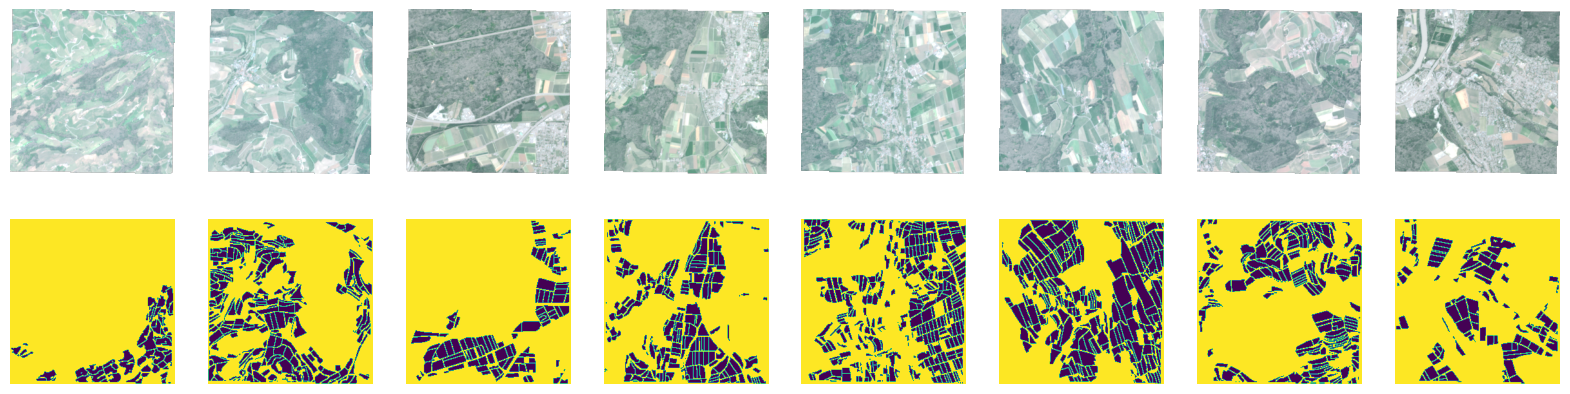

In [7]:
# Plot the images and masks
def plot_images(images, masks, num_images=8):
    fig, ax = plt.subplots(2, num_images, figsize=(20, 5))
    for i in range(num_images):
        ax[0, i].imshow(images[i])
        ax[0, i].axis('off')
        ax[1, i].imshow(masks[i])
        ax[1, i].axis('off')
    plt.show()
    
# Load the images and masks
for images, masks in val_data.dataset.take(1):
    plot_images(images, masks)
    
# Load the images and masks


In [22]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from helpers.UNET import UNET
from helpers.load import LoadandAugment
from keras import backend as K

# Base path for the dataset
path = "/workspaces/Satelite/data/dataset_upscaled_False"
train_path = os.path.join(path, "train")
val_path = os.path.join(path, "val")
test_path = os.path.join(path, "test")

# Initialize data loaders
train_data = LoadandAugment(train_path, "train", 32, True)
val_data = LoadandAugment(val_path, "val", 32, True)

# Jaccard coefficient (IoU) metric and loss function
def jacard_coef(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

# Initialize UNET model
unet = UNET(input_shape=(256, 256, 4))
unet.model.compile(optimizer='adam', loss=jacard_coef_loss, metrics=[jacard_coef])

# Setup the model checkpoint callback to save the best model
checkpoint_callback = ModelCheckpoint(
    'best_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)

# Train the model
unet.model.fit(
    train_data.dataset, 
    validation_data=val_data.dataset, 
    epochs=10, 
    callbacks=[checkpoint_callback]
)


Epoch 1/10
93/94 [============================>.] - ETA: 0s - loss: -0.6726 - jacard_coef: 0.6726
Epoch 1: val_loss improved from inf to -0.00421, saving model to best_model.h5
94/94 [==============================] - 33s 285ms/step - loss: -0.6727 - jacard_coef: 0.6735 - val_loss: -0.0042 - val_jacard_coef: 0.0041
Epoch 2/10
93/94 [============================>.] - ETA: 0s - loss: -0.7057 - jacard_coef: 0.7057
Epoch 2: val_loss improved from -0.00421 to -0.03801, saving model to best_model.h5
94/94 [==============================] - 26s 279ms/step - loss: -0.7058 - jacard_coef: 0.7064 - val_loss: -0.0380 - val_jacard_coef: 0.0380
Epoch 3/10
93/94 [============================>.] - ETA: 0s - loss: -0.7104 - jacard_coef: 0.7104
Epoch 3: val_loss improved from -0.03801 to -0.70865, saving model to best_model.h5
94/94 [==============================] - 27s 279ms/step - loss: -0.7105 - jacard_coef: 0.7110 - val_loss: -0.7087 - val_jacard_coef: 0.7093
Epoch 4/10
93/94 [=====================

In [4]:

import numpy as np
from helpers.UNET import UNET
import matplotlib.pyplot as plt

def plot_predictions(images, masks, predictions, num=6):
    plt.figure(figsize=(15, 5*num))
    
    for i in range(num):
        plt.subplot(num, 3, i*3+1)
        plt.imshow(images[i])
        plt.title("Satellite Image")
        plt.axis('off')
        
        plt.subplot(num, 3, i*3+2)
        plt.imshow(masks[i], cmap='gray')
        plt.title("Actual Mask")
        plt.axis('off')

        plt.subplot(num, 3, i*3+3)
        plt.imshow(predictions[i], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Jaccard coefficient (IoU) metric and loss function
def jacard_coef(y_true, y_pred):
    y_true_f = K.cast(K.flatten(y_true), 'float32')
    y_pred_f = K.cast(K.flatten(y_pred), 'float32')
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)

    
# Load the best model
unet = UNET(input_shape=(256, 256, 4))
unet.model.load_weights('best_model.h5')

# Evaluate the model
test_data = LoadandAugment(test_path, "test", 10, True)

# Predict on the test data
for images, masks in test_data.dataset:
    break
predictions = unet.model.predict(images)
predictions = (predictions > 0.5).astype(np.float32) 

# Plot the predictions
plot_predictions(images.numpy(), masks, predictions)


TypeError: ('Keyword argument not understood:', 'kernel_initalizer')